### The objective of this script is to generate the sequence of noise kicks, that are used for the simulations with Sixtracklib and PyHEADTAIL, such as they correspond to a measured spectrum.

**Methodology**
1) Load the measure spectrum, power spectral density in (dBc/Hz)

2) Convert the power spectral density in rad^2/Hz

3) Inverse Fourier transform of the square root of the noise power. Follow the procedure in PSD_to_NoiseSignal.ipynb

4) Scaling factor to the CC kick (both for RFMultipole in Sixtracklib and the momentum kick in PyHEADTAIL

5) Sanity check: Compute and plot the PSD of the resulted signal. Is it the same with the measured one?

In [57]:
import numpy as np
import pandas as pd
import pickle as pkl
import matplotlib.pyplot as plt

In [3]:
params = {'legend.fontsize': 16,
          'axes.labelsize': 17,
          'xtick.labelsize': 17,
          'ytick.labelsize': 17}

plt.rc('text', usetex=False)
plt.rcParams.update(params)

1) Load the data in a data frame and make them numpy.array for easier analysis

In [4]:
df = pd.read_csv("coast3EX-10DBm.csv")

In [5]:
df

,Offset Frequency (Hz),Phase Noise (dBc/Hz)
0,1000.000000,-103.746045
1,1018.009751,-103.823889
2,1036.343854,-104.874646
3,1055.008148,-104.950599
4,1074.008583,-105.575700
...,...,...
383,931091.255809,-144.238890
384,947859.977652,-143.591741
385,964930.700003,-143.434868
386,982308.861817,-143.406605


2) Convert the power spectral density in rad^2/Hz

\begin{equation}
S(f) = 2 \cdot 10^{L(f)/10}
\end{equation}

where $\rm S(f)$ the power spectral density in $ \rm rad^2/Hz$ and $\rm L(f)$ the measurement in $ \rm dBc/Hz$.
More in the presentation of 8July2020.

In [6]:
psd = 2*10**(np.array(df['Phase Noise (dBc/Hz)'])/10) # rad^2/Hz, type: numpy.array
freq = np.array(df['Offset Frequency (Hz)'])

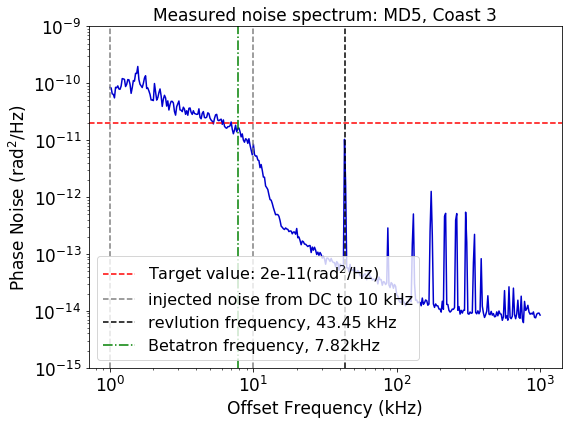

In [7]:
fig, ax1 = plt.subplots(figsize=(8,6))

ax1.plot(freq/1e3, psd, c='mediumblue')
ax1.set_xscale('log')
ax1.set_yscale('log')

ax1.set_ylim(10**(-15), 10**(-9))
ax1.set_xlabel('Offset Frequency (kHz)')
ax1.set_ylabel('Phase Noise '+ r'$\rm (rad^2/Hz)$')
ax1.axhline(2*10**(-110/10), c='r', linestyle='dashed', label='Target value: {}'.format(2*10**(-110/10))+r'$(\rm rad^2/Hz)$')

ax1.axvline(1, c='grey', linestyle='dashed')
ax1.axvline(10, c='grey', linestyle='dashed', label='injected noise from DC to 10 kHz')

ax1.axvline(43.45, c='k', linestyle='dashed', label='revlution frequency, 43.45 kHz')


ax1.axvline(0.18*43.45, c='g', linestyle='dashdot', label='Betatron frequency, {:.3}kHz'.format(0.18*43.45))


ax1.legend(loc=3)
ax1.set_title('Measured noise spectrum: MD5, Coast 3', fontsize=17)

plt.tight_layout()
#plt.savefig('Measured_spectrum_MD5_coast_3_target2e-11rad2perHz.png')

#### Linear interpolation

The measured data are equally spaced in logarithmic scale. We need to do a linear interpolation on the poewer spectral density to the wanted frequency array. 

- Sampling: dt = 1 (sequence of noise kicks applied every turn)
- Sampling frequency: 1/dt
- Length of signal: N, equals the turns of the simulations

In [36]:
dt = 1
df = 1/dt
N = 1e5
freq_3 = np.arange(0, N)*df

xx = np.interp(freq_3, freq, psd) # linear interpolation of the psd

In [50]:
# Convert the noise power to fft amplitude, A(f(k))
A = np.sqrt(xx*df*(N**2))
A[0] = 0 # set the 0 component to 0
A[freq_3 > 43.45e3] = np.sqrt(1e-15*df*N**2)  # For frequencies higher than the revolution frequency set a
# optional
A[freq_3 < 1e3] = np.sqrt(1e-15*df*N**2) 

In [51]:
#Give each spectral component a random phase, uniformly distributed between 0 and the frange, Phi(f(k))
phi = np.exp(1j*2*np.pi*np.random.uniform(0,1,len(freq_3)))

In [52]:
# Construct the FFT signal 
phaseerrorsfft = A*phi

In [53]:
# complex conjugate of all but the first element
phaseerrorsfft_conj = np.conj(phaseerrorsfft[1:])
# Reverse the list
reversed_list = phaseerrorsfft_conj[::-1]
# merge them
merged_list = list(phaseerrorsfft) + list(reversed_list)
merged_list[0] = 0

In [54]:
phaseerrors = np.real(np.fft.ifft(merged_list))

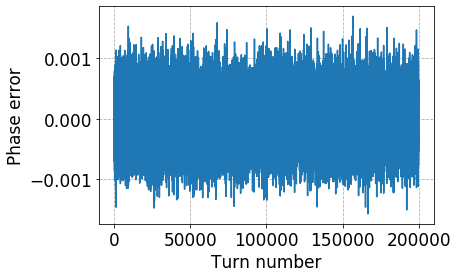

In [55]:
plt.plot(phaseerrors)
plt.xlabel('Turn number')
plt.ylabel('Phase error')
plt.grid(True, linestyle='--')

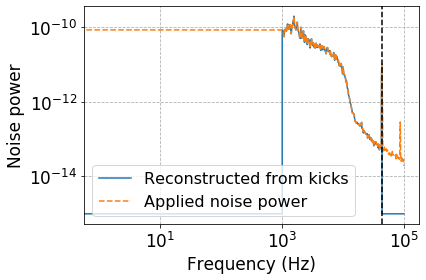

In [56]:
#Reconstruct the noise power spectrum from the phase errors
phaseerrorsfft1 = np.fft.fft(phaseerrors)
plt.plot(np.abs(phaseerrorsfft1[1:len(freq_3)])**2/(df*N**2), label='Reconstructed from kicks')
plt.plot(xx, label='Applied noise power', linestyle='--')
plt.legend(loc=3)
plt.xlabel('Frequency (Hz)')
plt.ylabel('Noise power')
plt.grid(True, linestyle='--')
plt.xscale('log')
plt.yscale('log')
plt.axvline(43.45e3, c='k', linestyle='dashed', label='revlution frequency, 43.45 kHz')

(0, 200)

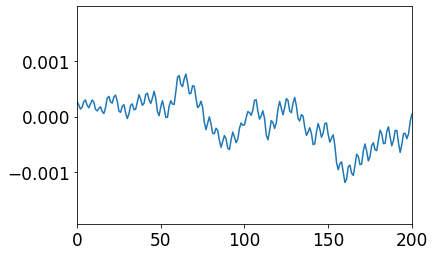

In [45]:
plt.plot(phaseerrors)
plt.xlim(0, 200)